In [48]:
import pandas as pd
import openpyxl
import gensim
from gensim import corpora
from pprint import pprint
import unicodedata as ud
import pymorphy2
from transliterate import translit, get_available_language_codes
from gensim import models
from gensim.utils import simple_preprocess

# doc_term_matrix = [dictionary.doc2bow(texts) ]

from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec
from gensim.models.phrases import Phrases
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import numpy as np
from os import listdir

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
import requests

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#read from csv files

# def format_string(strval):
#     return strval.split(sep=' ')[0]


# def read_from_file(filename):
#     raw_df = pd.DataFrame(columns = ['product_name', 'product_class'])
#     raw_df = pd.read_csv(filename, encoding_errors='ignore', delimiter=';', error_bad_lines=False, encoding='windows-1251', names=['product_name', 'product_class'])
#     raw_df = raw_df.drop_duplicates(subset=['product_name'], keep='first')
#     # raw_df = raw_df.drop_duplicates(subset=['product_class'], keep='first')к
#     # raw_df['product_name_short'] = raw_df['product_name'].apply(format_string)
#     # raw_df = raw_df.drop_duplicates(subset=['product_name_short'], keep='first')
#     return raw_df


# def find_csv_filenames(path_to_dir='product_names_extract/', suffix=".csv"):
#     filenames = listdir(path_to_dir)
#     return [(path_to_dir + filename) for filename in filenames if filename.endswith(suffix)]


# def split_dfs(df_list):
#     df = pd.DataFrame()
#     df = pd.concat(df_list)
#     return df

# def lang_detect(strval):
#     try:
#         return translator.detect(strval).lang
#     except:
#         return strval

# list_dfs = []
# for f in find_csv_filenames():
#     list_dfs.append(read_from_file(f))
# result_df = split_dfs(list_dfs)
# len(result_df)


df_raw = pd.read_excel('elastic_lang.xlsx')
# df_raw = df_raw.drop_duplicates(subset=['cyrillic'], keep='first')
len(df_raw)

df_raw['col'] = df_raw['cyrillic'].str.lower()

# result_df = result_df.drop_duplicates(subset=['product_name'], keep='first')
# lang_list = []
# for index, row in result_df.iterrows():
#     lang_list.append(translator.detect(row['product_name']))
# sampled_result_df = result_df.sample(n=10000)
# sampled_result_df['lang'] = sampled_result_df['product_name'].apply(lang_detect)
# sampled_result_df.to_csv()

In [50]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

df_lower = pd.DataFrame({'col':df_raw.col.unique()})
# df_lower['name'] = df_raw['col']
latin_letters= {} 

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha())

df_lower['latin'] = ''
df_lower['cyrillic'] = ''
df_lower['symbols'] = ''

df_lower = df_lower.fillna('')

def cyr_lat_symb_dividing(df_lower):
    new_df =  pd.DataFrame({'col':df_lower.col.unique()})
    new_df['latin'] = ''
    new_df['cyrillic'] = ''
    new_df['symbols'] = ''
    for i in range(len(df_lower)):
    #     if df_lower.col[i]:
        product = df_lower.col[i].split()
        for k in range(len(product)):
            if product[k][-1] in (',', '.'):
                word = product[k][:-1]
            else:
                word = product[k]
            if only_roman_chars(word) and word.isalpha():
                new_df.latin[i] += ' ' + word
            elif word.isalpha():
                new_df.cyrillic[i] += ' ' + word
            else:
                new_df.symbols[i] += ' ' + word
    return new_df



# futures = []
# chunk_len = len(df_lower)//12
# with ThreadPoolExecutor(max_workers=12) as executor:
#     for i in range(12):
#         futures.append(executor.submit(cyr_lat_symb_dividing, df_lower=df_lower[i*(chunk_len) : (i+1)*chunk_len -1]))
#     for future in concurrent.futures.as_completed(futures):
#         print(future.result())
    
#     print(future.result())


In [52]:
# Processing languages

import re
from googletrans import Translator
dfs = df_raw
translator = Translator(service_urls=["translate.google.com"])
def translate_to_ru(word):
    try:
        if (re.search(r"[ҲҒҚЎқҳғў]+", str(word))):
            result = str(translator.translate(word, src = 'uz', dest = 'ru').text)
            print(result)
            if len(result.split(separator = ' ')) < len(word.split(separator = ' ')):
                return str(word)
            else:
                return str(result)
        else:
            if str(word) == 'nan':
                return ''
            else:
                return str(word)
    except:
        return ''

russian = ['be', 'bs', 'bg', 'cs', 'pl', 'sr', 'sl', 'sk', 'uk', 'mk']
uzbek = ['az','kk','ky','tg','tt','tk']

def change_lang(lang):
    if lang in russian:
        return 'ru'
    if lang in uzbek:
        return 'uz'

def translate_from_uz(word):
    try:
        return translator.translate(word, dest='ru')
    except:
        return word
    
dfs['tokenized_lang'] = ''
dfs['tokenized_lang'] = dfs['tokenized_lang'][:100000].apply(change_lang)
dfs['translate_from_uzb'] = ''
dfs['translate_from_uzb'] = dfs['tokenized_lang'][:100000].apply(lambda x: translate_from_uz if x == 'uz' else x)
        

In [ ]:
# Abbreviations detection

import re

def detect_abr(word):
    match = re.search(word, r'^[\s\t\n]*[A-ZА-Яа-яa-z]{2,4}[0-9\\\*\-\/\.\,\s]*(([\s\t\n]*[a-zа-я]+)|([\s\t\n]*))$')
    if match:
        return True
    else:
        return False


df['col'] = df['col'].str.lower()

df_lower = pd.DataFrame({'col':df.col.unique()})

print (df_lower)

In [54]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
nltk.download('punkt')


url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt"
corpus = dfs['cyrillic'].str.cat(sep = ' ')
corpus_list =  [corpus]

def get_text(url, encoding='utf-8', to_lower=True):
    url = str(url)
    if url.startswith('http'):
        r = requests.get(url)
        if not r.ok:
            r.raise_for_status()
        return r.text.lower() if to_lower else r.text
    elif os.path.exists(url):
        with open(url, encoding=encoding) as f:
            return f.read().lower() if to_lower else f.read()
    else:
        raise Exception('parameter [url] can be either URL or a filename')


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=4):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [str(tok)
              for tok in tokens
              if tok not in stopwords and len(str(tok)) >= min_length]
    return tokens


def tokenize_n_lemmatize(
    text, stopwords=None, normalize=True, 
    regexp=r'(?u)\b\w{4,}\b'):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(text, stopwords)
    words_w_trans = []
    for w in words:
        words_w_trans.append(str(translate_to_ru(w)))
    return words_w_trans
    return words

stopwords_ru = get_text(url_stopwords_ru).splitlines()

## Extend stopwords
week_ru_stopwords = ["неделя", "понедельник", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье"]

week_uz_stopwords = ["хафта", "hafta", "xafta", "dushanba", "душанба", "seshanba", "сешанба", "chorshanba", "чоршанба", 
                     "payshanba", "пайшанба", "juma", "джума", "жума", "shanba", "шанба", "yakshanba", "якшанба"]

month_ru_stopwords = ["месяц", "январь", "февраль", "март", "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]

month_uz_stopwords  = ["oy", "ой", "yanvar",  "fevral", "mart", "aprel", "may", "iyun", "iyul", "avgust", "sentyabr", "oktyabr", "noyabr", "dekabr", 
                      "январ", "феврал", "март", "апрел", "май", "июн", "июл", "август", "сентябр", "октябр", "ноябр", "декабр"]

year_stopwords = ["год", "йил", "yil"]

extend_stopwords = [] + week_ru_stopwords + week_uz_stopwords + month_ru_stopwords + month_uz_stopwords + year_stopwords

stopwords_ru += extend_stopwords

words = tokenize_n_lemmatize(corpus, stopwords=stopwords_ru)

# df_ready = pd.DataFrame(columns = ['cyrillic'])
# df_ready['cyrillic'] = words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DaniyarM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
d:\Projects\Jupyter\jupyter_venv\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
d:\Projects\Jupyter\jupyter_venv\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
d:\Projects\Jupyter\jupyter_venv\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
d:\Projects\Jupyter\jupyter_venv\lib\site

In [6]:
# dfs['tokenized'] = dfs['cyrillic'].apply(lambda x: tokenize_n_lemmatize(str(x)))

In [55]:
nan_value = float("NaN")
df_lower.replace("", nan_value, inplace=True)

df_lower.dropna(subset = ["cyrillic"], inplace=True)
texts = df_lower['cyrillic'].to_list()

In [32]:
# from gensim.models.word2vec import Text8Corpus
# from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# phrase_model = Phrases(df_ready['cyrillic'], min_count=10, threshold=1, connector_words=frozenset("в на за под и но а при около как ".split()))

In [56]:
w2v_model = Word2Vec(
    min_count=10,
    vector_size=10,
    window=2,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

data = [doc.split() for doc in df_ready['cyrillic']]

w2v_model.build_vocab(data)
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

w2v_model.init_sims(replace=True)

C:\Temp/ipykernel_13432/3926067427.py:16: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
d:\Projects\Jupyter\jupyter_venv\lib\site-packages\gensim\models\word2vec.py:909: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  self.wv.init_sims(replace=replace)


In [58]:
 w2v_model.wv.most_similar(positive=["вода"], topn=10)

[('родниковая', 0.9705761671066284),
 ('питаьевая', 0.959426999092102),
 ('монтелла', 0.9555803537368774),
 ('саирме', 0.9527862071990967),
 ('капсулах', 0.951346755027771),
 ('питьевая', 0.9459636807441711),
 ('негазированная', 0.9407490491867065),
 ('газированная', 0.9390128254890442),
 ('бутилированная', 0.9361154437065125),
 ('фосфоцинео', 0.9173895716667175)]

C:\Temp/ipykernel_13432/2829663449.py:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vectors_words = [model.wv.word_vec(word)]
C:\Temp/ipykernel_13432/2829663449.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Temp/ipykernel_13432/2829663449.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Temp/ipykernel_13432/2829663449.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Temp/ipykernel_13432/2829663449.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Temp/ipykernel_13432/2829663449.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
C:\Temp/ipyker

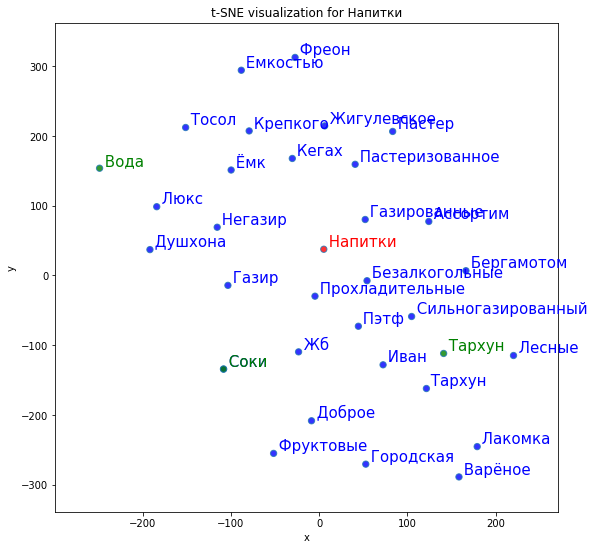

In [60]:
##Scatter of Word2Vec model

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction 
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']
    close_words = model.wv.most_similar(word, topn=30)
    for wrd_score in close_words:
        wrd_vector = model.wv.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.word_vec(wrd)
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        if wrd in close_words:
            color_list.append('black')
        else:
            color_list.append('green')
        
    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))
#     plt.savefig('напитки.jpg')
tsne_scatterplot(w2v_model, "напитки", ["тархун", "вода", "соки"])

In [ ]:
def normalize_token(token):
    morph = pymorphy2.MorphAnalyzer()
    return morph.parse(token.lower())[0].normal_form 


def mean_for_vecs(sentence):
    if len(sentence.split(sep = ' ')) > 1:
        text_vector = np.mean([w2v_model.wv[normalize_token(word)] for word in sentence.split(sep = ' ')[1:]], axis=0)
    else:
        text_vector = w2v_model.wv[word]
    return text_vector

df_mean_vec = pd.DataFrame(columns = ['sentence', 'vec'])
sentences =[]
df_lower = df_lower.reset_index(drop=True)
vecs = []
for i in range(len(df_lower['cyrillic'])):
#     if df_lower.col[i]:
    try:
        vecs.append(mean_for_vecs(df_lower['cyrillic'][i]))
        sentences.append(df_lower['cyrillic'][i])
    except Exception as e :
        print(e)

df_mean_vec['sentence'] = sentences
df_mean_vec['vec'] = vecs


In [107]:
##K-Means clusterer for Word2Vec model

from sklearn import cluster
from sklearn import metrics


X = df_mean_vec['vec']

from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=300
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

words = df_mean_vec['sentence']

# words = list(w2v_model.wv.index_to_key)
# cluster_dict = {}
# for i, word in enumerate(words):  
# #     cluster_dict[str(word)] = str(i)
    
#     print (word + ":" + str(assigned_clusters[i]))
    




KeyboardInterrupt: 

In [65]:
cluster_dict = {}
for i, word in enumerate(words):  
    cluster_dict[str(word)] = str(assigned_clusters[i])

In [104]:
df_clusters = pd.DataFrame({'word': words, 'cluster': assigned_clusters})

In [106]:

df_clusters.to_excel('tmp_df.xlsx')

In [84]:
kmeans = cluster.KMeans(n_clusters=100)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[36 36  6 ... 58 83 46]
Centroids data
[[-5.80234230e-02 -8.05051029e-02  3.41765374e-01 -3.90781283e-01
  -2.91422069e-01  4.05641854e-01  5.58526218e-02 -4.21065688e-02
  -4.35909718e-01 -3.02904129e-01]
 [-2.00947821e-01  1.76214829e-01  3.96456659e-01  2.33565047e-01
   2.77823031e-01 -1.89857483e-02  4.88305062e-01 -9.57314149e-02
  -3.89505416e-01 -1.69569105e-01]
 [ 8.02519545e-02  2.31539443e-01 -9.41058993e-03  2.11497545e-02
   3.44323575e-01  1.88451469e-01  2.99830586e-01 -2.02337831e-01
  -6.35089457e-01  1.01694733e-01]
 [-3.09985578e-01 -6.67519569e-02 -2.57907063e-01 -2.08728343e-01
   1.48082584e-01  3.27973902e-01  5.79913557e-01 -7.76942670e-02
  -3.37583840e-01 -1.15644395e-01]
 [-2.34198838e-01 -2.39103101e-02  1.19268462e-01 -4.08650875e-01
   4.57114488e-01  2.90758014e-01  1.40031114e-01 -1.55672953e-01
  -4.46649045e-01 -1.69281811e-01]
 [-2.05191135e-01 -4.12759751e-01  1.79405928e-01 -1.66012719e-02
   2.87219793e-01  1.993